# Pierre feuille ciseaux avec IA

## Import des bibliothèques nécessaires

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import choice,shuffle
from scipy import stats as st

from collections import deque

## Étape 1: Collecte de données pour les classes pierre, feuille, ciseaux et rien.

In [25]:
def gather_data(num_samples):
    
    global rock, paper, scissor, nothing
    
    # Initialisation de la caméra
    cap = cv2.VideoCapture(0,  cv2.CAP_DSHOW)

    # trigger nous indique quand commencer l'enregistrement
    trigger = False
    
    # Counter garde le compte du nombre d'échantillons collectés
    counter = 0
    
    # C'est la taille de la ROI, la taille des images enregistrées sera box_size -10
    box_size = 234
    
    # Obtention de la largeur de la frame à partir des propriétés de la caméra
    width = int(cap.get(3))


    while True:
        
        # Lire frame par frame
        ret, frame = cap.read()
        
        # Retourner la frame latéralement
        frame = cv2.flip(frame, 1)
        
        # Rompre la boucle s'il y a un problème de lecture de la frame.
        if not ret:
            break
            
        # Si le compteur est égal au nombre d'échantillons, réinitialiser le déclencheur et le compteur
        if counter == num_samples:
            trigger = not trigger
            counter = 0
        
        # Définir ROI pour la capture d'échantillons
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
        # Créer une fenêtre redimensionnable.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
        
        
        # Si le déclencheur est True alors commencer à capturer les échantillons
        if trigger:
            
            # Prendre seulement la ROI sélectionnée
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
            
            # Ajouter la ROI et le nom de la classe à la liste avec le nom de classe sélectionné
            eval(class_name).append([roi, class_name])
                                    
            # Incrémenter le compteur 
            counter += 1 
        
            # Texte pour le compteur
            text = "Échantillons collectés de {}: {}".format(class_name, counter)
            
        else:
            text = "Appuyez sur 'p' pour collecter des échantillons de pierre, 'f' pour le feuille, 'c' pour ciseaux et 'r' pour rien"
        
        # Afficher le compteur sur l'image
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
        
        # Afficher la fenêtre
        cv2.imshow("Collecting images", frame)
        
        # Attendre 1 ms
        k = cv2.waitKey(1)
        
        # Si l'utilisateur appuie sur 'p', définir le chemin pour le répertoire de pierre (rock)
        if k == ord('p'):
            
            # Déclencher la variable pour capturer les échantillons
            trigger = not trigger
            class_name = 'rock'
            rock = []
           
            
        # Si l'utilisateur appuie sur 'f', alors le nom de la classe est défini sur feuille (paper) et le déclencheur est défini sur True  
        if k == ord('f'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
        
        # Si l'utilisateur appuie sur 'c', alors le nom de la classe est défini sur ciseaux (scissor) et le déclencheur est défini sur True  
        if k == ord('c'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                    
        # Si l'utilisateur appuie sur 'r', alors le nom de la classe est défini sur rien (nothing) et le déclencheur est défini sur True
        if k == ord('r'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
        
        # Sortir si l'utilisateur appuie sur 'q'
        if k == ord('q'):
            break
            
    # Libérer la caméra et fermer la fenêtre
    cap.release()
    cv2.destroyAllWindows()

In [26]:
# Nombre total d'échantillons à collecter
no_of_samples = 100
gather_data(no_of_samples)

## Étape 2: Visualiser les données:

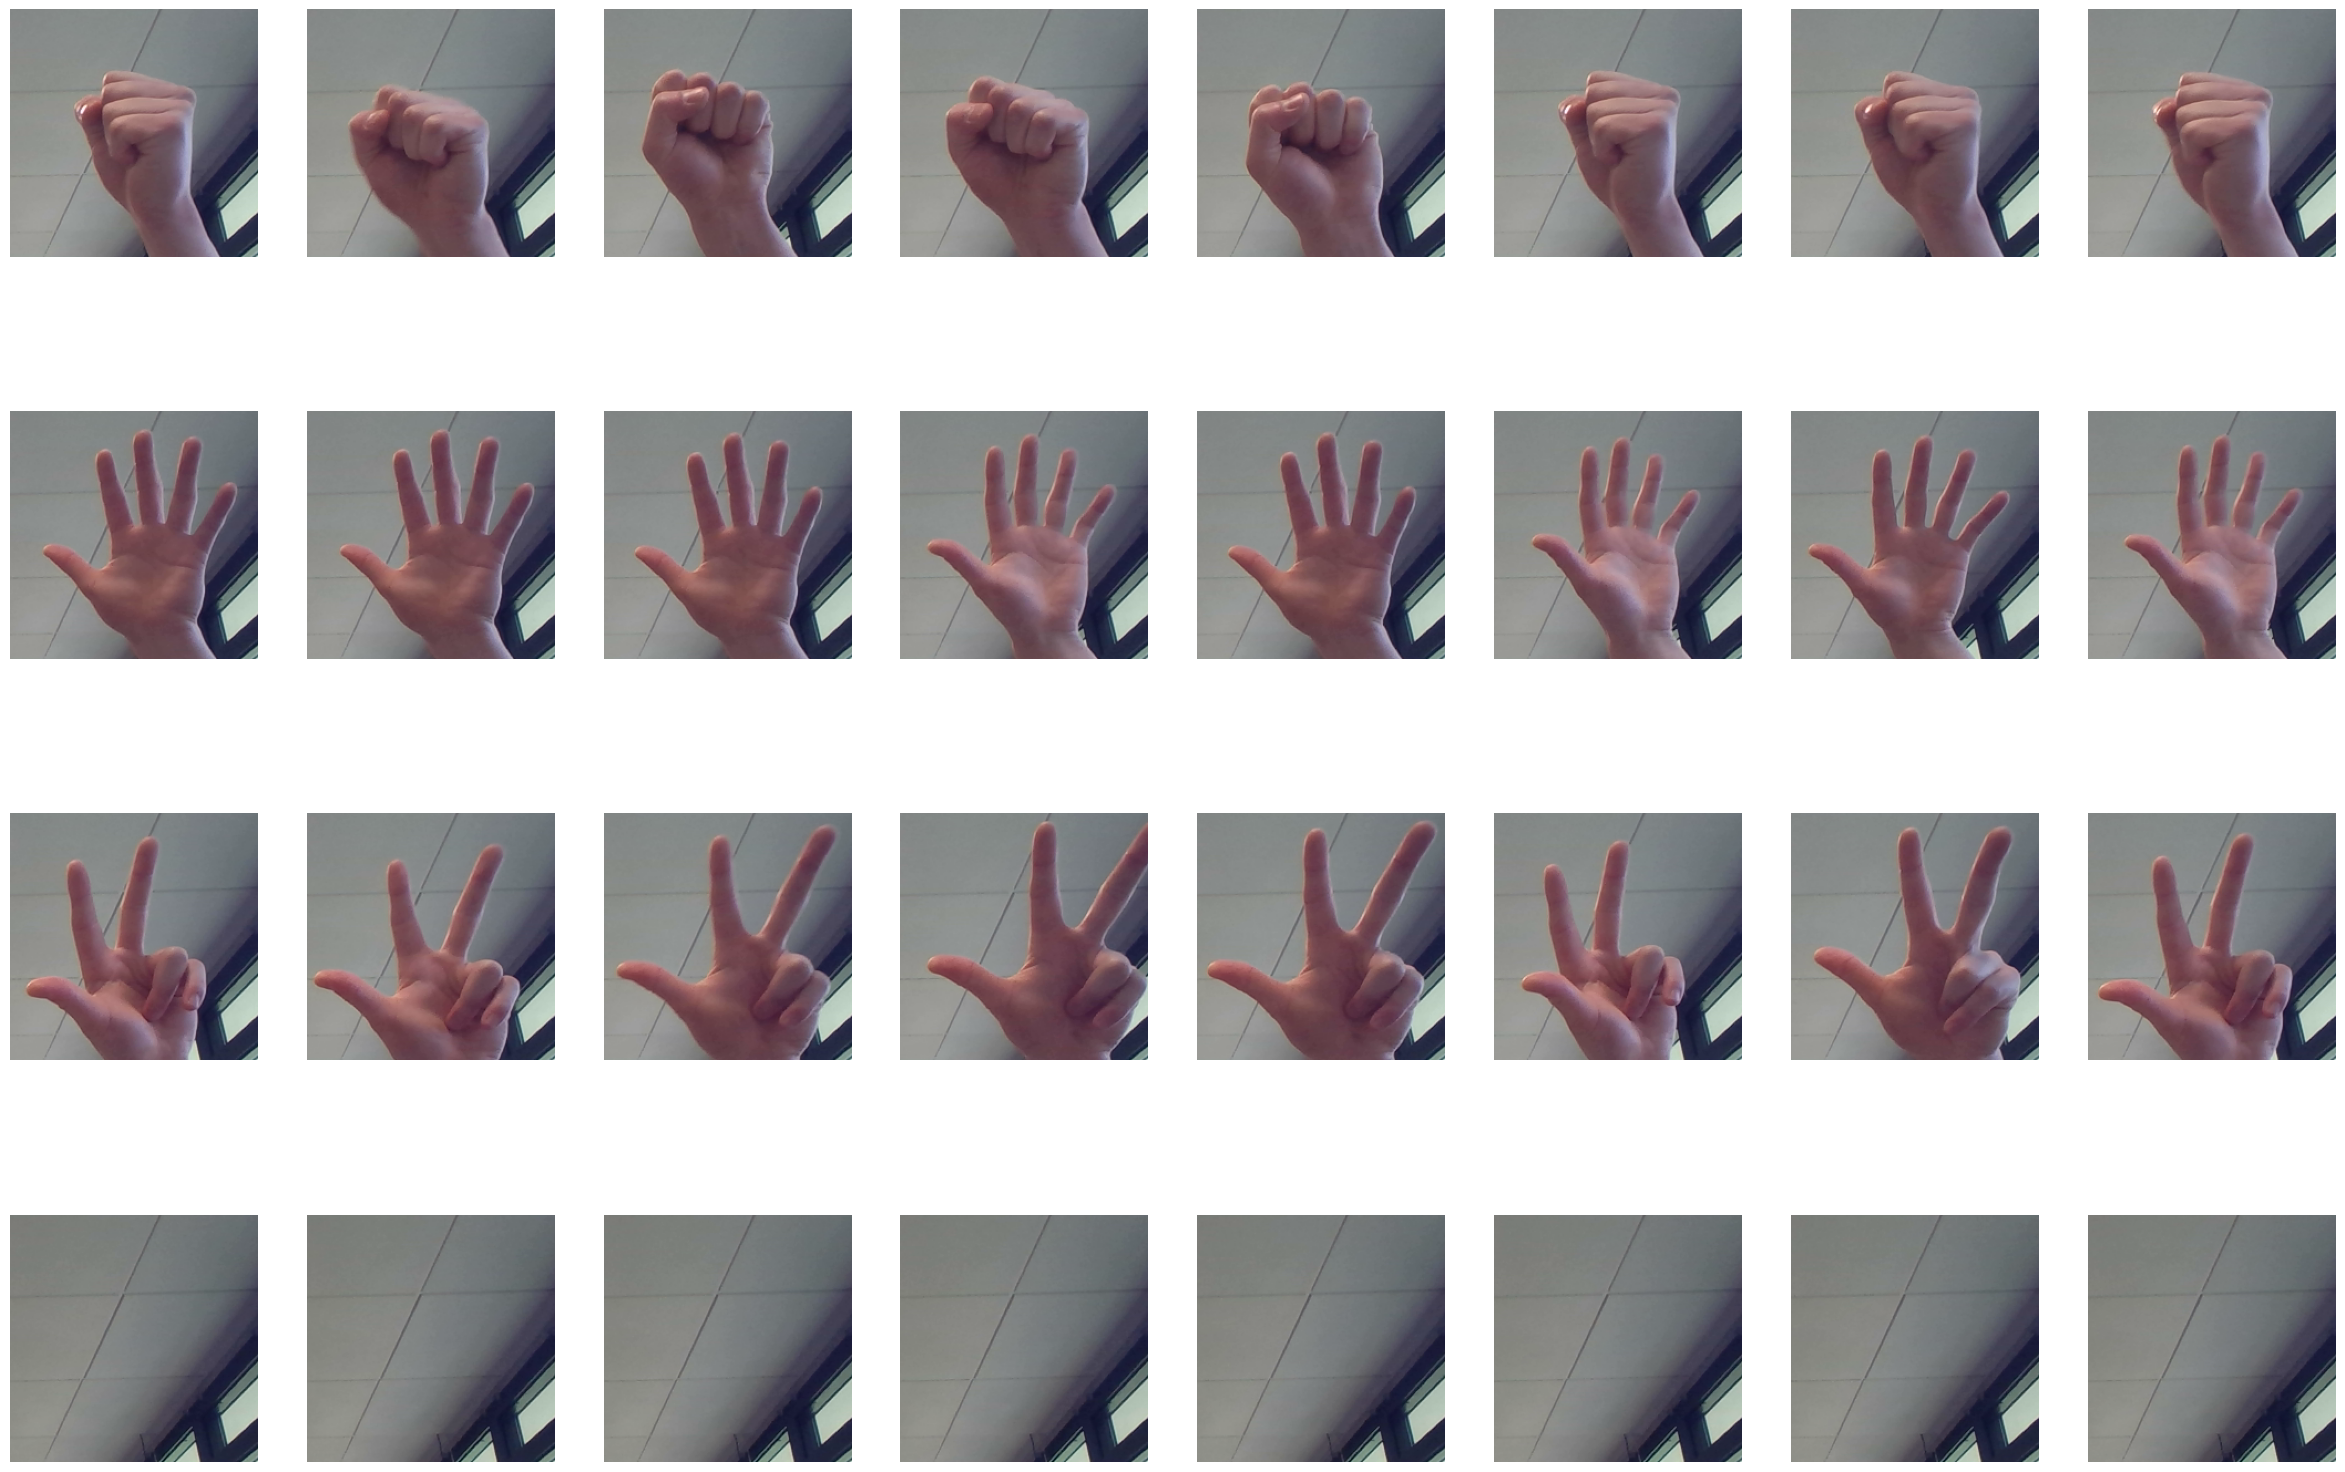

In [27]:
# Définir la taille de la figure
plt.figure(figsize=[30,20])

# Définir les lignes et colonnes
rows, cols = 4, 8

# Itérer pour chaque classe
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
    
    # Obtenir 8 indexes aléatoires, car nous allons montrer 8 exemples de chaque classe.
    r = np.random.randint(no_of_samples, size=8);
    
    # Tracer les exemples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');   

## Étape 3: Prétraiter les données et les diviser:

In [28]:
# Combiner les labels de toutes les classes ensemble
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]

# Combiner les images de toutes les classes ensemble
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]

# Normaliser les images en divisant par 255, maintenant nos images sont dans la plage 0-1. Cela aidera à l'entraînement.
images = np.array(images, dtype="float") / 255.0

# Afficher le nombre total de labels et d'images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))

# Créer un objet d'encodeur
encoder = LabelEncoder()

# Convertir les étiquettes en entiers. c'est-à-dire rien = 0, papier = 1, roche = 2, ciseaux = 3 (mapping est fait dans l'ordre alphabétique)
Int_labels = encoder.fit_transform(labels)

# Maintenant, convertir les étiquettes entières en format one hot. c'est-à-dire 0 = [1,0,0,0] etc.
one_hot_labels = to_categorical(Int_labels, 4)

# Maintenant, nous divisons les données, 75% pour l'entraînement et 25% pour le test.
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)

# Libérer la mémoire de la RAM
images = []

Total images: 400 , Total Labels: 400


## Étape 4: Préparer notre modèle pour le Fine Tuning:

In [29]:
# Ceci est la taille d'entrée que notre modèle accepte.
image_size = 224

# Chargement du modèle NASNETMobile pré-entraîné sans la tête en faisant include_top = False
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Geler le modèle entier 
N_mobile.trainable = False
    
# Ajout de notre propre tête personnalisée
# Commencez par prendre les cartes de fonctionnalités de sortie de NASNETMobile
x = N_mobile.output

# Convertir en un vecteur unidimensionnel par Global Average Pooling. 
# Nous pourrions également utiliser Flatten()(x) GAP est plus efficace, réduit les paramètres et contrôle le surajustement.
x = GlobalAveragePooling2D()(x)

# Ajout d'une couche dense avec 512 unités
x = Dense(712, activation='relu')(x) 

# Rejet de 20% des activations, aide à réduire le surajustement
x = Dropout(0.40)(x)

# La couche finale contiendra 4 unités de sortie (nombre d'unités = nombre de classes) avec une fonction softmax.
preds = Dense(4,activation='softmax')(x) 

# Construire le modèle complet
model = Model(inputs=N_mobile.input, outputs=preds)

# Vérifier le nombre de couches dans le modèle final
print ("Nombre de couches dans le modèle: {}".format(len(model.layers[:])))

Nombre de couches dans le modèle: 773


## Étape 5: Entraîner notre modèle:

In [30]:
# Ajout de transformations qui je sais aideraient, vous pouvez ajouter plus librement.
# Je fais horizontal_flip = False, au cas où vous ne seriez pas sûr de quelle main vous utiliseriez, vous pouvez le mettre à True.

augment = ImageDataGenerator( 
    
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,    
        fill_mode="nearest"
)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Définir la taille du batch selon votre système
epochs = 15
batchsize = 20

In [33]:
# Commencer l'entraînement
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 35s 924ms/step - loss: 0.9172 - accuracy: 0.7000 - val_loss: 0.3930 - val_accuracy: 0.9100
Epoch 2/15
15/15 [==============================] - 7s 465ms/step - loss: 0.3040 - accuracy: 0.9567 - val_loss: 0.1850 - val_accuracy: 0.9400
Epoch 3/15
15/15 [==============================] - 7s 467ms/step - loss: 0.1323 - accuracy: 0.9933 - val_loss: 0.1141 - val_accuracy: 0.9600
Epoch 4/15
15/15 [==============================] - 7s 486ms/step - loss: 0.1100 - accuracy: 0.9800 - val_loss: 0.0778 - val_accuracy: 1.0000
Epoch 5/15
15/15 [==============================] - 7s 501ms/step - loss: 0.0638 - accuracy: 0.9900 - val_loss: 0.0500 - val_accuracy: 1.0000
Epoch 6/15
15/15 [==============================] - 8s 502ms/step - loss: 0.0469 - accuracy: 0.9933 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 7/15
15/15 [==============================] - 7s 492ms/step - loss: 0.0433 - accuracy: 0.9967 - val_loss: 0.0295 - val_accuracy: 1.0000
Epoch

## Étape 6: Vérifier notre précision, graphiques de perte et sauvegarder le modèle.

In [34]:
# Tracer les courbes de précision et de perte

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

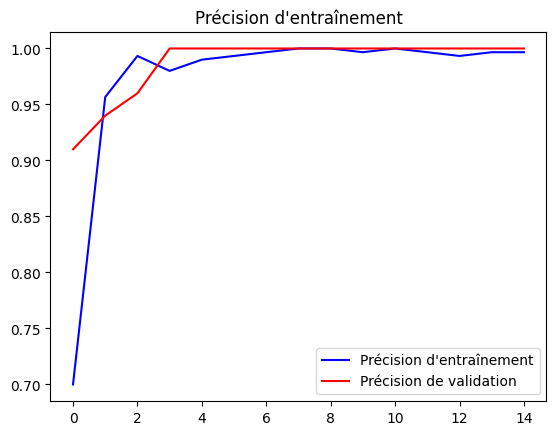

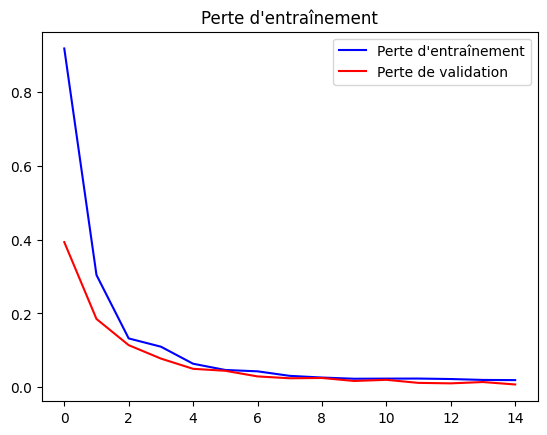

In [35]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Précision d\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision d\'entraînement')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte d\'entraînement')
plt.legend()

plt.show()

In [36]:
# Sauvegarder le modèle
model.save("rps4.keras", overwrite=True)

In [37]:
# Charger le modèle
model = load_model("rps4.keras")

## Étape 7: Test sur un flux Webcam en direct:

In [38]:
# Cette liste sera utilisée pour mapper les probabilités aux noms de classe, les noms de label sont dans l'ordre alphabétique.
label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
box_size = 234
width = int(cap.get(3))

while True:
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    # Normaliser l'image comme nous l'avons fait dans l'étape de prétraitement, également convertir en tableau float64.
    roi = np.array([roi]).astype('float64') / 255.0
 
    # Obtenir la prédiction du modèle.
    pred = model.predict(roi)
    
    # Obtenir l'index de la classe cible.
    target_index = np.argmax(pred[0])

    # Obtenir la probabilité de la classe cible
    prob = np.max(pred[0])

    # Afficher les résultats
    cv2.putText(frame, "prédiction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Rock Paper Scissors", frame)
    
   
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 59ms/step


## Étape 8: Créer l'Application Finale:

In [39]:
import cv2
import numpy as np
import random
import time  # Importation du module time pour les délais

# Cette liste sera utilisée pour mapper les probabilités aux noms de classe, les noms de label sont dans l'ordre alphabétique.
label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
box_size = 234
width = int(cap.get(3))

# Scores
user_score = 0
computer_score = 0

while True:
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    # Normaliser l'image comme nous l'avons fait dans l'étape de prétraitement, également convertir en tableau float64.
    roi = np.array([roi]).astype('float64') / 255.0
 
    # Obtenir la prédiction du modèle.
    pred = model.predict(roi)
    
    # Obtenir l'index de la classe cible.
    target_index = np.argmax(pred[0])

    # Obtenir la probabilité de la classe cible
    prob = np.max(pred[0])

    # Afficher le choix de l'utilisateur
    user_choice = label_names[target_index]
    cv2.putText(frame, "Votre choix: {}".format(user_choice),
                (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    
    if user_choice != 'nothing':
        # Ajouter un délai avant de révéler le choix de l'ordinateur
        for i in range(3, 0, -1):
            cv2.putText(frame, str(i),
                        (width // 2 - 20, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)
            cv2.imshow("Rock Paper Scissors", frame)
            cv2.waitKey(1000)  # Délai de 1 seconde
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
        
        # Choix de l'ordinateur
        computer_choice = random.choice(['rock', 'paper', 'scissor'])
        
        # Déterminer le gagnant
        winner = ''
        if (user_choice == 'rock' and computer_choice == 'scissor') or \
           (user_choice == 'scissor' and computer_choice == 'paper') or \
           (user_choice == 'paper' and computer_choice == 'rock'):
            user_score += 1
            winner = 'Utilisateur'
        elif (computer_choice == 'rock' and user_choice == 'scissor') or \
             (computer_choice == 'scissor' and user_choice == 'paper') or \
             (computer_choice == 'paper' and user_choice == 'rock'):
            computer_score += 1
            winner = 'Ordinateur'
        
        # Afficher le choix de l'ordinateur
        cv2.putText(frame, "Choix de l'ordinateur: {}".format(computer_choice),
                    (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Afficher le gagnant
        if winner:
            cv2.putText(frame, "Gagnant: {}".format(winner),
                        (10, 160), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Afficher les scores
        cv2.putText(frame, "Score de l'utilisateur: {}".format(user_score),
                    (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, "Score de l'ordinateur: {}".format(computer_score),
                    (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Afficher les résultats pendant quelques secondes
        cv2.imshow("Rock Paper Scissors", frame)
        cv2.waitKey(3000)  # Délai de 3 secondes
        
        # Vérifier la condition de fin de partie (le meilleur de cinq)
        if user_score == 3 or computer_score == 3:
            if user_score == 3:
                cv2.putText(frame, "L'utilisateur gagne!",
                            (10, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                cv2.putText(frame, "L'ordinateur gagne!",
                            (10, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
                
            # Réinitialiser les scores pour un nouveau jeu
            user_score = 0
            computer_score = 0
            
            # Ajouter un délai avant de commencer une nouvelle partie
            time.sleep(3)  # Délai de 3 secondes
    
    cv2.imshow("Rock Paper Scissors", frame)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 54ms/step
